# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd

df = pd.read_csv('twitter-archive-enhanced.csv')

In [91]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df.tail(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8,10,the,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",My oh my. This is a rare blond Canadian terrie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090...,9,10,a,None,None,None,None
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a Siberian heavily armored polar bear ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525...,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
import requests

r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [5]:
import os

if not 'image-predictions.tsv' in os.listdir():
    with open ('image-predictions.tsv', 'wb') as file:
        file.write(r.content)

In [6]:
from io import StringIO

with open ('image-predictions.tsv', 'rb') as file:
    file = file.read().decode('utf8')
df_im_pred = pd.read_csv(StringIO(file), sep='\t')

In [7]:
df_im_pred.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1904,852189679701164033,https://pbs.twimg.com/media/C9OV99SXsAEmj1U.jpg,1,barrow,0.423150,False,Bernese_mountain_dog,0.415374,True,EntleBucher,0.067345,True
1341,758828659922702336,https://pbs.twimg.com/media/Cofmom_VUAA4dRO.jpg,1,Chesapeake_Bay_retriever,0.480048,True,vizsla,0.264522,True,Weimaraner,0.121840,True
1487,782021823840026624,https://pbs.twimg.com/media/CdHwZd0VIAA4792.jpg,1,golden_retriever,0.383223,True,cocker_spaniel,0.165930,True,Chesapeake_Bay_retriever,0.118199,True
1035,711743778164514816,https://pbs.twimg.com/media/CeCfMPDW0AAAEUj.jpg,1,Lakeland_terrier,0.459515,True,miniature_poodle,0.219661,True,standard_poodle,0.130189,True
923,702276748847800320,https://pbs.twimg.com/media/Cb78-nOWIAENNRc.jpg,1,Boston_bull,0.697303,True,French_bulldog,0.239015,True,American_Staffordshire_terrier,0.019838,True
558,677698403548192770,https://pbs.twimg.com/media/CWerGmOXAAAm6NY.jpg,1,Shih-Tzu,0.916645,True,Lhasa,0.057883,True,Pekinese,0.020126,True
1543,791406955684368384,https://pbs.twimg.com/media/CvukbEkWAAAV-69.jpg,4,Pembroke,0.972629,True,Cardigan,0.027026,True,basenji,0.000153,True
733,686749460672679938,https://pbs.twimg.com/media/CYfS75fWAAAllde.jpg,1,cheeseburger,0.643808,False,hotdog,0.201378,False,bagel,0.063880,False
1327,757393109802180609,https://pbs.twimg.com/media/CoLNAq6WAAAkmdJ.jpg,2,Labrador_retriever,0.787125,True,Chesapeake_Bay_retriever,0.112676,True,Rottweiler,0.048039,True
865,697463031882764288,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,1,Labrador_retriever,0.999885,True,golden_retriever,0.000098,True,pug,0.000008,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [8]:
df_twits_counter = pd.read_json('tweet-json.txt', lines=True)

In [9]:
df_twits_counter.sample(10).iloc[:, 0:10]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id
571,2016-11-23 04:45:12+00:00,801285448605831168,801285448605831168,oh h*ck 10/10 https://t.co/bC69RrW559,False,"[0, 13]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 801285440351240192, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN
407,2017-01-23 17:20:14+00:00,823581115634085888,823581115634085888,This is Crawford. He's quite h*ckin good at th...,False,"[0, 106]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 823581103512436736, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN
1484,2016-01-29 16:30:45+00:00,693109034023534592,693109034023534592,"""Thank you friend that was a swell petting"" 11...",False,"[0, 99]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 693108992730632192, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN
892,2016-07-30 01:22:17+00:00,759197388317847553,759197388317847552,This is Luna. She's just heckin precious af I ...,False,"[0, 77]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 759197380596170757, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN
308,2017-02-25 17:06:32+00:00,835536468978302976,835536468978302976,RT @dog_rates: Meet Lola. Her hobbies include ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN
686,2016-10-17 15:31:05+00:00,788039637453406209,788039637453406208,Did... did they pick out that license plate? 1...,False,"[0, 59]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 788039617207472128, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN
1082,2016-06-02 16:10:29+00:00,738402415918125056,738402415918125056,"""Don't talk to me or my son ever again"" ...10/...",False,"[0, 57]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 738402403196796928, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN
1115,2016-05-17 01:00:32+00:00,732375214819057664,732375214819057664,This is Kyle (pronounced 'Mitch'). He strives ...,False,"[0, 113]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 732375209307705344, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN
981,2016-07-03 00:14:27+00:00,749395845976588288,749395845976588288,This is George. He just remembered that bees a...,False,"[0, 110]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 749395837562843136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN
547,2016-12-04 19:02:24+00:00,805487436403003392,805487436403003392,Meet Sansa and Gary. They run along the fence ...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 805487414768701441, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [10]:
df.shape

(2356, 17)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [13]:
df[df.rating_numerator == 1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [14]:
df.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [15]:
df_im_pred.shape

(2075, 12)

In [16]:
df_im_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
df_im_pred.p1.value_counts().head(42)

golden_retriever                  150
Labrador_retriever                100
Pembroke                           89
Chihuahua                          83
pug                                57
chow                               44
Samoyed                            43
toy_poodle                         39
Pomeranian                         38
cocker_spaniel                     30
malamute                           30
French_bulldog                     26
miniature_pinscher                 23
Chesapeake_Bay_retriever           23
seat_belt                          22
Siberian_husky                     20
German_shepherd                    20
Staffordshire_bullterrier          20
Cardigan                           19
web_site                           19
Eskimo_dog                         18
Maltese_dog                        18
Shetland_sheepdog                  18
teddy                              18
beagle                             18
Lakeland_terrier                   17
Rottweiler  

In [18]:
df_twits_counter.shape

(2354, 31)

In [19]:
df_twits_counter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

### Quality issues
1. In twitter archive there is an inconsistency in data type: timestamp should be datetime objects. Also there are some ID columns in float format however since these columns refer to retweets and replies I will delete them after deleting respective rows (see p. 2)

2. There are a number of retweets which begin from 'RT'. I will delete them from the dataset.

3. There are a number of replies which are non-null entries in col in_reply_to_status_id. I will delete them from the dataset.

4. Dataset with image predictions contains a lot of mistakes (e.g., such breeds as web-site, fire-engine, seat_belt and others). I will delete them from the dataset.

5. In the dataset received from tweet-json there a lot of unnecessary columns. I will delete all columns except for ID, retweet_count and favorite_count.

6. Make all breeds' names in lower case

7. There is a number of numerators that are too high to have any meaning. I will make a cap for numerators at 20 which is twice high than standard denominator of 10.

8. There is a number of denominators that are different from standard denominator of 10. I will delete all such records as they could be erroneous.

### Tidiness issues

1. The tables 'twitter-archive-enhanced' and 'tweet-json' are identical and from the last one I need two columns only: favorite count and retweet count. Thus I will join these two columns to the first table by tweet ID.

2. The tables 'twitter-archive-enhanced' contains categories 'doggo', 'floofer', 'pupper' and 'puppo'. I will replace all Nones with 0 and all the categories names with 1.

3. Also the table with images does not have any separate meaning. Thus I will join the data on images and 'twitter-archive-enhanced' by tweet ID.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [20]:
# Make copies of original pieces of data

df_clean = df.copy()

In [21]:
df_im_pred_clean = df_im_pred.copy()

In [22]:
df_twits_counter_clean = df_twits_counter.copy()

### Issue #1:
In twitter archive there is an inconsistency in data type: timestamp should be datetime objects.

#### Define:
For change of timestamp I will use to_datetime method.

#### Code

In [23]:
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)

#### Test

In [24]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Issue #2: 
There are a number of retweets which begin from 'RT'. I will delete them from the dataset.

#### Define:
Here I will use drop method for non-null entries in retweeted status id columns.

#### Code

In [25]:
mask = df_clean[df_clean.retweeted_status_id.notnull()]

In [26]:
df_clean.drop(labels=mask.index, inplace=True)

#### Test

In [27]:
df_clean.text.str.startswith('RT').sum()

2

Let's check what 2 entries beginning with RT remained.

In [28]:
df_clean[df_clean.text.str.startswith('RT')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1286,708400866336894977,NaN,NaN,2016-03-11 21:15:02+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",RT if you are as ready for summer as this pup ...,NaN,NaN,NaN,https://vine.co/v/iHFqnjKVbIQ,12,10,None,None,None,None,None
1860,675489971617296384,NaN,NaN,2015-12-12 01:38:53+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT until we find this dog. Clearly a cool dog ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675489971...,10,10,None,None,None,None,None


As we can see these entries are not retweets but rather are a call to make a retweet. So we can leave it as it is.

### Issue #3: 
There are a number of replies which are non-null entries in col in_reply_to_status_id.

#### Define:
Here I will us drop method for non-null entries in in_reply_to_status_id column.

#### Code

In [29]:
mask = df_clean[df_clean.in_reply_to_status_id.notnull()]

In [30]:
df_clean.drop(labels=mask.index, inplace=True)

#### Test

In [31]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2097 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2097 non-null   datetime64[ns, UTC]
 4   source                      2097 non-null   object             
 5   text                        2097 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2097 non-null   int64           

Now we can delete all columns with 0 non-null rows.

In [32]:
df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

In [33]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

### Issue #4:
Dataset with image predictions contains a lot of mistakes (e.g., such breeds as web-site, fire-engine, seat_belt and others).

#### Define:
All entries where the image is recognised as something that is not dog have False value in p1_dog column. So I should use drop method to delete such entries. Also p2 and p3 related columns do not have any sense for our data analysis. They should also be deleted using drop method,

#### Code

In [34]:
mask = df_im_pred_clean[df_im_pred_clean.p1_dog == False]

In [35]:
df_im_pred_clean.drop(labels=mask.index, inplace=True)

In [36]:
df_im_pred_clean.drop(columns=['p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)

#### Test

In [37]:
df_im_pred_clean.p1_dog.value_counts()

True    1532
Name: p1_dog, dtype: int64

In [38]:
df_im_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 2073
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1532 non-null   int64  
 1   jpg_url   1532 non-null   object 
 2   img_num   1532 non-null   int64  
 3   p1        1532 non-null   object 
 4   p1_conf   1532 non-null   float64
 5   p1_dog    1532 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 73.3+ KB


### Issue #5:
In the dataset received from tweet-json there a lot of unnecessary columns. 

#### Define:
I will delete all columns except for ID, retweet_count and favorite_count using drop method.

#### Code

In [39]:
df_twits_counter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [40]:
columns = df_twits_counter_clean.columns[np.r_[0, 2:20, 22:31]].values

In [41]:
df_twits_counter_clean.drop(columns=columns, inplace=True)

#### Test

In [42]:
df_twits_counter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


### Issue #6:
Make all breeds' names in lower case

#### Define:
To make all breeds' names in lower case in order to get consistency I will use str.lower method.

#### Code

In [43]:
df_im_pred_clean.p1 = df_im_pred_clean.p1.str.lower()

#### Test

In [44]:
df_im_pred_clean.p1.value_counts()

golden_retriever      150
labrador_retriever    100
pembroke               89
chihuahua              83
pug                    57
                     ... 
japanese_spaniel        1
scotch_terrier          1
standard_schnauzer      1
entlebucher             1
clumber                 1
Name: p1, Length: 111, dtype: int64

### Issue #7:
There is a number of numerators that are too high to have any meaning. I will make a cap for numerators at 20 which is twice high than standard denominator of 10.

#### Define:
I will make mask to choose all records with rating numerator exceeding 20. Then I will use drop method to delete records in accordance with the mask.

#### Code

In [45]:
mask = df_clean[df_clean.rating_numerator > 20]

In [46]:
df_clean.drop(mask.index, inplace=True)

#### Test

In [47]:
df_clean.rating_numerator.value_counts()

12    486
10    436
11    413
13    287
9     153
8      98
7      52
14     38
5      34
6      32
3      19
4      16
2       9
1       5
0       1
Name: rating_numerator, dtype: int64

### Issue #8:
There is a number of denominators that are different from standard denominator of 10. I will delete all such records as they could be erroneous.

#### Define:
I will make mask to choose all records with rating denominator not equal to 10. Then I will use drop method to delete records in accordance with the mask.

#### Code

In [48]:
mask = df_clean[df_clean.rating_denominator != 10]

In [49]:
df_clean.drop(mask.index, inplace=True)

#### Test

In [50]:
df_clean.rating_denominator.value_counts()

10    2075
Name: rating_denominator, dtype: int64

### Tidiness issues

### Issue #1:
The tables 'twitter-archive-enhanced' and 'tweet-json' are identical and from the last one I need two columns only: favorite count and retweet count. Thus I will join these two columns to the first table by tweet ID.

#### Define:
I will use merge method to join the two dataframes. However to do this I need to rename column 'id' in df_twits_counter_clean dataframe to 'tweet_id' in order the columns had the same name. For this purpose I will use rename method.

#### Code

In [51]:
df_twits_counter_clean.rename({'id': 'tweet_id'}, axis=1, inplace=True)

In [52]:
df_clean = df_clean.merge(df_twits_counter_clean, on='tweet_id')

#### Test

In [53]:
df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,8853,39467
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,6514,33819
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,4328,25461
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,8964,42908
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,9774,41048


### Issue #2:
The tables 'twitter-archive-enhanced' contains categories 'doggo', 'floofer', 'pupper' and 'puppo'. I will replace all Nones with 0 and all the categories names with 1

#### Define:
I will use str.replace method to clear the identified issue. I will make it in cycle for every column in scope. Also here I will change the type of the data from str to int using astype method.

#### Code

In [56]:
columns = ['doggo', 'floofer', 'pupper', 'puppo']

for col in columns:
    df_clean[col] = df_clean[col].str.replace('None', '0')
    df_clean[col] = df_clean[col].str.replace(col, '1')
    df_clean[col].astype(int)

#### Test

In [57]:
df_clean.sample(20)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
826,743510151680958465,2016-06-16 18:26:48+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Beya. She doesn't want to swim, so she...",https://twitter.com/dog_rates/status/743510151...,13,10,Beya,0,0,0,0,4185,8671
1955,668221241640230912,2015-11-22 00:15:33+00:00,"<a href=""http://twitter.com/download/iphone"" r...",These two dogs are Bo &amp; Smittens. Smittens...,https://twitter.com/dog_rates/status/668221241...,10,10,None,0,0,0,0,215,537
1169,699088579889332224,2016-02-15 04:31:20+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Charl. He's a bully. Chucks that dumbb...,https://twitter.com/dog_rates/status/699088579...,3,10,Charl,0,0,0,0,715,2451
1214,695446424020918272,2016-02-05 03:18:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",We normally don't rate unicorns but this one h...,https://twitter.com/dog_rates/status/695446424...,12,10,None,0,0,0,0,2026,4787
97,870804317367881728,2017-06-03 00:48:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Real funny guys. Sending in a pic without a do...,https://twitter.com/dog_rates/status/870804317...,11,10,None,0,0,0,0,6393,33791
705,757393109802180609,2016-07-25 01:52:43+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo completely oblivious to the dou...,https://twitter.com/dog_rates/status/757393109...,10,10,None,1,0,0,0,2009,6462
1070,707610948723478529,2016-03-09 16:56:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Harper. She scraped her elbow attempti...,https://twitter.com/dog_rates/status/707610948...,12,10,Harper,0,0,0,0,7236,18557
601,774314403806253056,2016-09-09 18:31:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC B...,https://twitter.com/dog_rates/status/774314403...,14,10,None,0,0,0,0,6478,24167
1567,676440007570247681,2015-12-14 16:34:00+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Hope your Monday isn't too awful. Here's two b...,https://twitter.com/dog_rates/status/676440007...,11,10,None,0,0,0,0,748,1863
1822,670755717859713024,2015-11-29 00:06:39+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Gin &amp; Tonic. They're having a...,https://twitter.com/dog_rates/status/670755717...,9,10,Gin,0,0,0,0,123,475


### Issue #3:
The table with images does not have any separate meaning. Thus I will join the data on images and 'twitter-archive-enhanced' by tweet ID.

#### Define:
I will join the above mentioned 2 dataframes using merge method on 'tweet_id' column.

#### Code

In [60]:
df_clean = df_clean.merge(df_im_pred_clean, on='tweet_id')

#### Test

In [61]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1445
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1446 non-null   int64              
 1   timestamp           1446 non-null   datetime64[ns, UTC]
 2   source              1446 non-null   object             
 3   text                1446 non-null   object             
 4   expanded_urls       1446 non-null   object             
 5   rating_numerator    1446 non-null   int64              
 6   rating_denominator  1446 non-null   int64              
 7   name                1446 non-null   object             
 8   doggo               1446 non-null   object             
 9   floofer             1446 non-null   object             
 10  pupper              1446 non-null   object             
 11  puppo               1446 non-null   object             
 12  retweet_count       1446 non-null 

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [62]:
df_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [63]:
df = pd.read_csv('twitter_archive_master.csv')

In [68]:
df.groupby(by='p1', sort=False).favorite_count.mean().sort_values(ascending=False)

p1
saluki                     24060.000000
french_bulldog             17913.000000
afghan_hound               17326.666667
giant_schnauzer            17314.500000
black-and-tan_coonhound    17012.000000
                               ...     
groenendael                 1896.000000
tibetan_terrier             1841.000000
japanese_spaniel            1362.000000
ibizan_hound                1114.666667
brabancon_griffon            885.000000
Name: favorite_count, Length: 110, dtype: float64

In [69]:
df.groupby(by='p1', sort=False).rating_numerator.mean().sort_values(ascending=False)

p1
saluki                         12.500000
briard                         12.333333
tibetan_mastiff                12.250000
border_terrier                 12.142857
silky_terrier                  12.000000
                                 ...    
ibizan_hound                    9.000000
norwich_terrier                 9.000000
walker_hound                    9.000000
soft-coated_wheaten_terrier     8.250000
japanese_spaniel                5.000000
Name: rating_numerator, Length: 110, dtype: float64

In [70]:
df.groupby(by='p1', sort=False).retweet_count.mean().sort_values(ascending=False)

p1
standard_poodle           6631.857143
afghan_hound              5976.000000
english_springer          5973.555556
giant_schnauzer           5161.500000
saluki                    5133.750000
                             ...     
welsh_springer_spaniel     517.000000
japanese_spaniel           471.000000
ibizan_hound               431.000000
groenendael                413.000000
brabancon_griffon          287.666667
Name: retweet_count, Length: 110, dtype: float64

In [75]:
df_group_by_favorite = pd.DataFrame(df.groupby(by='p1', sort=False).favorite_count.mean())
df_group_by_retweet = pd.DataFrame(df.groupby(by='p1', sort=False).retweet_count.mean())
df_group_by_rating = pd.DataFrame(df.groupby(by='p1', sort=False).rating_numerator.mean())

In [78]:
df_group_by_mean = df_group_by_favorite.merge(df_group_by_retweet, on='p1')

In [79]:
df_group_by_mean = df_group_by_mean.merge(df_group_by_rating, on='p1')

In [153]:
df_group_by_mean.sort_values('rating_numerator', ascending=False)

,favorite_count,retweet_count,rating_numerator
p1,,,
saluki,24060.000000,5133.750000,12.500000
briard,9511.666667,2966.666667,12.333333
tibetan_mastiff,12173.500000,4193.000000,12.250000
border_terrier,13578.000000,3377.142857,12.142857
silky_terrier,7317.000000,1891.000000,12.000000
...,...,...,...
ibizan_hound,1114.666667,431.000000,9.000000
norwich_terrier,6018.250000,1735.000000,9.000000
walker_hound,6589.800000,2656.600000,9.000000


In [83]:
df_group_by_mean.corr()

,favorite_count,retweet_count,rating_numerator
favorite_count,1.000000,0.927875,0.512340
retweet_count,0.927875,1.000000,0.468134
rating_numerator,0.512340,0.468134,1.000000


In [158]:
df.name.value_counts()

None          338
a              42
Cooper         10
Charlie        10
Oliver          9
             ... 
Davey           1
Fizz            1
Jackson         1
Carbon          1
Christoper      1
Name: name, Length: 758, dtype: int64

### Insights:

1. While the amount of favorites/retweets not always agrees with the author of the blog rating, there are some consistencies. We can see that saluki dogs are adorable by the author and her audience while japanese spaniel has consistently low ratings.

2. We see very strong dependency between favorites and retweets means across the breeds. It seems that users who make retweets also click favorite button.

3. Cooper, Charlie and Oliver are the most popular dog names in our population.

### Visualization

Here I will visualize the relative comparison of average amounts of favorites, retweets and rating by top 10 breeds chosen by average amount of favorites. In order to make the data visually comparable I will multiply rating by 1000.

In [85]:
df_top10_by_mean = df_group_by_mean.sort_values('favorite_count', ascending=False)[0:10]

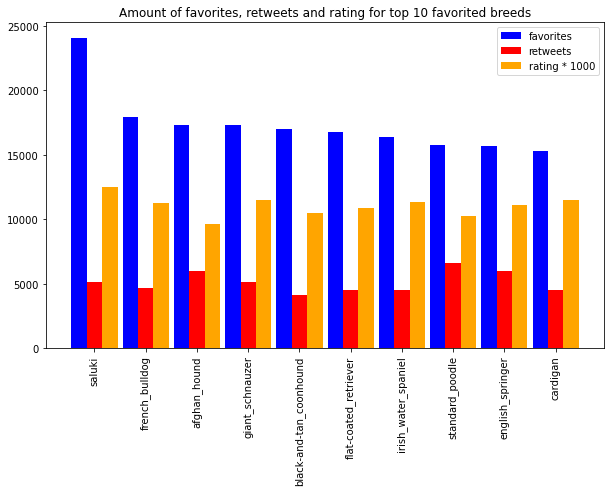

In [150]:
plt.figure(figsize=[10,6]);
ax = plt.subplot(111);
ax.bar(np.arange(10) - 0.3, df_top10_by_mean.favorite_count, width=0.3, align='center', color='b');
ax.bar(np.arange(10), df_top10_by_mean.retweet_count, width=0.3, align='center', color='r');
ax.bar(np.arange(10) + 0.3, df_top10_by_mean.rating_numerator*1000, width=0.3, align='center', color='orange');
plt.xticks(ticks=np.arange(10), labels=list(df_top10_by_mean.index.values), rotation=90);
plt.legend(labels=['favorites', 'retweets', 'rating * 1000']);
plt.title('Amount of favorites, retweets and rating for top 10 favorited breeds');